In [20]:
import re
import random
import pandas as pd
import hashlib

In [21]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [22]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
"Lost in a Good Book, Fforde",20.846782,4.169356,9.778747,5
Power BI,160.212071,4.854911,13.286375,33
Pandas,306.050078,34.005564,87.739208,9
DAX,660.174701,73.352745,259.912445,9
CCH Axcess,677.997257,23.379216,64.494522,29
Azure DevOps Pipelines,707.582495,70.758250,159.825448,10
Azure AD Authentication,728.313395,91.039174,209.932470,8
Azure Private DNS,848.676951,94.297439,250.814817,9
Azure Functions + PP365,903.585161,64.541797,111.389843,14
Terraform,1013.036359,84.419697,319.852660,12


# Histogram

sum of ages: ~41071.73


<Axes: >

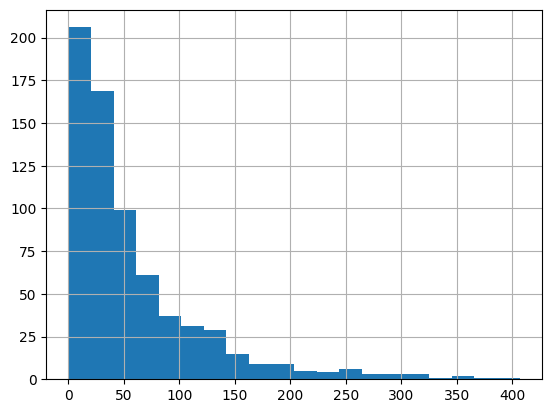

In [23]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~41071.73


<Axes: >

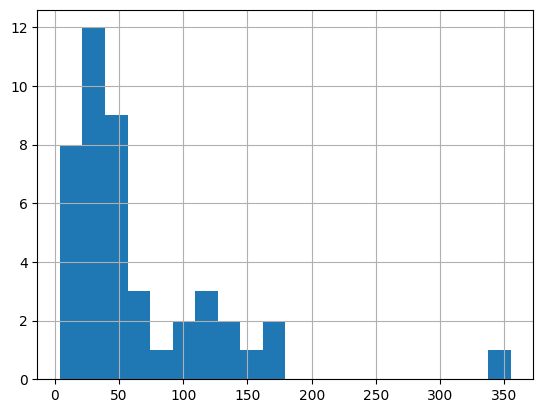

In [24]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [25]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [26]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [27]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [28]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [29]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [30]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [31]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [32]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [33]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 694
Total card age: 41071.73


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
197,Azure Private DNS,Custom DNS Server\nDefinition: A DNS server sp...,1310bffcb725da50801088ba06e53d6d,-250.814817,-94.297439,250.814817,848.676951,0.041317,9,0,0
198,Azure Private DNS,Public DNS Zone\nDefinition: A DNS zone used f...,80e3b5c7443f8b328a9b72703ac533d7,-72.834989,-94.297439,250.814817,848.676951,0.041317,9,3,0
199,Azure Private DNS,SOA Record (Start of Authority Record):\nDefin...,f67d3b95c385c32a54f23aa53796ce3d,-28.126032,-94.297439,250.814817,848.676951,0.041317,9,6,0
200,Azure AD Authentication,Role Inheritance\nRoles assigned at a higher s...,f486e8cb803022299b90de35918dc51e,-209.932470,-91.039174,209.932470,728.313395,0.139671,8,0,0
201,Azure AD Authentication,Custom Roles\nUser-defined roles with specific...,8353d48893b25d8b5c181da274bcd9df,-74.047328,-91.039174,209.932470,728.313395,0.139671,8,3,0
202,Azure AD Authentication,App Registration\nRegisters an app in Azure AD...,a907c4524daeebbcef1c778a937dcbb2,-36.938824,-91.039174,209.932470,728.313395,0.139671,8,6,0
38,Asynchronous Python,asyncio.Future\nA low-level object representin...,b901a57e93a160736ed15c21d112b8b1,-406.694566,-90.890129,406.694566,3453.824893,0.523240,38,0,0
39,Asynchronous Python,asyncio.Lock\nAn asynchronous lock in Python u...,55373a57f263c98c77342352e17bae06,-217.241241,-90.890129,406.694566,3453.824893,0.523240,38,3,0
40,Asynchronous Python,asyncio.shield()\nPrevents a coroutine in Pyth...,a150295cf95ed464cfd29d1e584b7b7d,-181.294794,-90.890129,406.694566,3453.824893,0.523240,38,6,0
41,Asynchronous Python,Event Loop\nThe core of Python’s asyncio syste...,701a585ad1039e35383053c0bbf6bc60,-109.885239,-90.890129,406.694566,3453.824893,0.523240,38,9,0


## Age Max

In [34]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [35]:
# n=10
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'frequency', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [36]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [37]:
if existing_cards.age.sum() < 0:
    asc = True
else: asc = False
existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
38,Asynchronous Python,asyncio.Future\nA low-level object representin...,b901a57e93a160736ed15c21d112b8b1,-406.694566,-90.890129,406.694566,3453.824893,0.523240,38,0,0
101,FSLogix,Q: How does FSLogix improve Office 365 perform...,f35dc0360cf624fcdfa25708f25b7398,-367.661574,-81.890512,367.661574,2538.605868,0.426561,31,0,0
134,Azure Compute Gallery,SAS Token (Shared Access Signature) – A tempor...,16543cefaf9d760fb4860bf0a6fcb4bb,-356.566312,-66.901100,356.566312,2207.736312,0.782229,33,0,0
86,Azure Developer Associate,The .NET SDK for Azure Cosmos DB for NoSQL shi...,f5da4a10007b58ba8af2aaafb7b97a48,-355.188645,-65.204530,355.188645,2868.999323,0.986112,44,0,0
276,Asynchronous Python,Coroutine Object\nThe result of calling an asy...,877cc6e7d0264598007bf336b88f4c3e,-331.203584,-90.890129,406.694566,3453.824893,0.523240,38,1,1
188,Terraform,You can create and use Terraform modules that ...,dee44c7482afdda345bd10bdad89f932,-319.852660,-84.419697,319.852660,1013.036359,0.275743,12,0,0
112,PowerShell Modules,PSReadLine Module\n\nDefinition: A module that...,b41f499c95e1fc0bd9767a6315e4b432,-319.458381,-89.314425,319.458381,2411.489465,0.921253,27,0,0
338,FSLogix,Redirector Driver:\nA mechanism within FSLogix...,f51a72bfb75cf817d822f0fb50b94a12,-315.728079,-81.890512,367.661574,2538.605868,0.426561,31,1,1
15,JavaScript Concepts,Using Object.keys() with for...of Loop: The Ob...,06c15a040f743007e381b243ccc3d915,-292.807469,-56.730476,292.807469,3800.941904,0.339297,67,0,0
161,C# Basics,What are common libraries and frameworks in C#...,d714cbc1740b344f84ed84278b332f36,-290.815876,-69.229754,290.815876,1661.514097,0.272678,24,0,0


In [38]:
existing_cards['age'].mean()

-59.18117280865825